# SimFin Tutorial 08 - Statistical Analysis

[Original repository on GitHub](https://github.com/simfin/simfin-tutorials)

This tutorial was originally written by [Hvass Labs](https://github.com/Hvass-Labs)

----

"So logically, if she weighs the same as a duck, she's made of wood, and therefore a witch!"
&ndash; [Monty Python's Holy Grail](https://www.youtube.com/watch?v=zrzMhU_4m-g)

## Introduction

In the previous tutorial we showed how to implement a basic stock-screener using the SimFin API and financial data. One of the screeners we created was for so-called NetNet-stocks, which are stocks that sell at a discount to a very conservative estimate of their liquidation value. This is an old investment strategy invented by Ben Graham, who was the teacher of Warren Buffett.

The previous tutorial was a good example of how people use stock-screeners: They have some hypothesis that a given valuation ratio or other financial signal can be used to predict future stock-returns. But how can we really know that there is a relation between some financial signal and future stock-returns? The first step is to use statistical analysis, which is the topic of this tutorial.

We will again use the NetNet example because it is simple and demonstrates the method well. But we could also have studied e.g. how financial signals might predict future sales-growth, or whatever else we might be interested in.

It is assumed you are already familiar with the basics of the SimFin API.

## Imports

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

# Import the main functionality from the SimFin Python API.
import simfin as sf

# Import names used for easy access to SimFin's data-columns.
from simfin.names import *

In [2]:
# Version of the SimFin Python API.
sf.__version__

'0.6.0'

## SimFin Config

In [3]:
# SimFin data-directory.
sf.set_data_dir('~/simfin_data/')

In [4]:
# SimFin load API key or use free data.
sf.load_api_key(path='~/simfin_api_key.txt', default_key='free')

In [5]:
# Seaborn set plotting style.
sns.set_style("whitegrid")

## Data Hub

We use a `StockHub` object to easily load and process financial data with these settings:

In [6]:
# We are interested in the US stock-market.
market = 'us'

# Add this date-offset to the fundamental data such as
# Income Statements etc., because the REPORT_DATE is not
# when it was actually made available to the public,
# which can be 1, 2 or even 3 months after the Report Date.
offset = pd.DateOffset(days=60)

# Refresh the fundamental datasets (Income Statements etc.)
# every 30 days.
refresh_days = 30

# Refresh the dataset with shareprices every 10 days.
refresh_days_shareprices = 10

In [7]:
%%time
hub = sf.StockHub(market=market, offset=offset,
                  refresh_days=refresh_days,
                  refresh_days_shareprices=refresh_days_shareprices)

CPU times: user 23 µs, sys: 5 µs, total: 28 µs
Wall time: 34.6 µs


## Signals

First we calculate financial signals for the stocks, such as the Current Ratio, Debt Ratio, Net Profit Margin, Return on Assets, etc. These are calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [8]:
%%time
df_fin_signals = hub.fin_signals(variant='daily')

Dataset "us-income-ttm" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-balance-ttm" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-ttm" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-shareprices-daily" on disk (0 days old).
- Loading from disk ... Done!
Cache-file 'fin_signals-2a38bb7d.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 12.7 s, sys: 1.15 s, total: 13.9 s
Wall time: 13.9 s


Now we calculate growth signals for the stocks, such as Earnings Growth, FCF Growth, Sales Growth, etc. These are also calculated using data from the financial reports: Income Statements, Balance Sheets and Cash-Flow Statements, which are automatically downloaded and loaded by the data-hub.

In [9]:
%%time
df_growth_signals = hub.growth_signals(variant='daily')

Dataset "us-income-quarterly" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-balance-quarterly" on disk (12 days old).
- Loading from disk ... Done!
Dataset "us-cashflow-quarterly" on disk (12 days old).
- Loading from disk ... Done!
Cache-file 'growth_signals-2a38bb7d.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 913 ms, sys: 325 ms, total: 1.24 s
Wall time: 1.23 s


Now we calculate valuation signals for the stocks, such as P/E, P/Sales, etc. These are calculated from the share-prices and data from the financial reports. Because the data-hub has already loaded the required datasets in the function-calls above, the data is merely reused here, and the data-hub can proceed directly to computing the signals.

In [10]:
%%time
df_val_signals = hub.val_signals(variant='daily')

Cache-file 'val_signals-739b68a6.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 158 ms, sys: 317 ms, total: 475 ms
Wall time: 472 ms


We now combine all the signals into a single DataFrame:

In [11]:
%%time
# Combine the DataFrames.
dfs = [df_fin_signals, df_growth_signals, df_val_signals]
df_signals = pd.concat(dfs, axis=1)

CPU times: user 1.68 s, sys: 291 ms, total: 1.97 s
Wall time: 1.97 s


We can then show the results:

In [12]:
df_signals.dropna(how='all').head()

(Dividends + Share Buyback) / FCF  Asset Turnover  \
Ticker Date                                                            
A      2011-06-29                           0.168927        0.711759   
       2011-06-30                           0.168927        0.711759   
       2011-07-01                           0.168927        0.711759   
       2011-07-05                           0.168927        0.711759   
       2011-07-06                           0.168927        0.711759   

                   CapEx / (Depr + Amor)  Current Ratio  Debt Ratio  \
Ticker Date                                                           
A      2011-06-29               0.590551       3.201005     0.24789   
       2011-06-30               0.590551       3.201005     0.24789   
       2011-07-01               0.590551       3.201005     0.24789   
       2011-07-05               0.590551       3.201005     0.24789   
       2011-07-06               0.590551       3.201005     0.24789   

                   Dividends / FCF  Gross Profit Margin  Interest Coverage  \
Ticker Date                                                                  
A      2011-06-29             -0.0             0.532001          10.890411   
       2011-06-30             -0.0             0.532001          10.890411   
       2011-07-01             -0.0             0.532001          10.890411   
       2011-07-05             -0.0             0.532001          10.890411   
       2011-07-06             -0.0             0.532001          10.890411   

                   Inventory Turnover  Log Revenue  ...  Earnings Yield  \
Ticker Date                                         ...                   
A      2011-06-29            7.216882     9.789299  ...        0.049626   
       2011-06-30            7.216882     9.789299  ...        0.049121   
       2011-07-01            7.216882     9.789299  ...        0.048280   
       2011-07-05            7.216882     9.789299  ...        0.048598   
       2011-07-06            7.216882     9.789299  ...        0.048448   

                   FCF Yield    Market-Cap    P/Book    P/Cash        P/E  \
Ticker Date                                                                 
A      2011-06-29   0.045221  1.793416e+10  4.527684  6.028287  20.150736   
       2011-06-30   0.044761  1.811850e+10  4.574222  6.090250  20.357860   
       2011-07-01   0.043995  1.843400e+10  4.653875  6.196303  20.712360   
       2011-07-05   0.044284  1.831347e+10  4.623446  6.155788  20.576933   
       2011-07-06   0.044148  1.837019e+10  4.637766  6.174854  20.640663   

                       P/FCF     P/NCAV   P/NetNet   P/Sales  
Ticker Date                                                   
A      2011-06-29  22.113631  43.956262 -29.990226  2.913281  
       2011-06-30  22.340931  44.408076 -30.298487  2.943225  
       2011-07-01  22.729963  45.181373 -30.826087  2.994477  
       2011-07-05  22.581344  44.885956 -30.624532  2.974898  
       2011-07-06  22.651282  45.024975 -30.719381  2.984111  

[5 rows x 42 columns]

## Missing Data

Some of the signals have a lot of missing data which causes problems in the statistical analysis. Let us first see the fraction of each signal-column that is missing:

In [13]:
# Remove all rows with only NaN values.
df = df_signals.dropna(how='all').reset_index(drop=True)

# For each column, show the fraction of the rows that are NaN.
(df.isnull().sum() / len(df)).sort_values(ascending=False)

R&D / Revenue                        0.643162
R&D / Gross Profit                   0.643008
Return on Research Capital           0.643008
Net Acquisitions / Total Assets      0.537681
Dividend Yield                       0.525758
Inventory Turnover                   0.330476
Debt Ratio                           0.323155
Sales Growth                         0.222090
Earnings Growth                      0.207079
Assets Growth                        0.206687
FCF Growth                           0.206687
Sales Growth YOY                     0.182991
Interest Coverage                    0.182798
Earnings Growth YOY                  0.169052
FCF Growth YOY                       0.168602
Assets Growth YOY                    0.168602
CapEx / (Depr + Amor)                0.107068
P/Sales                              0.096983
P/Cash                               0.084485
P/Book                               0.083337
Earnings Yield                       0.083337
P/NCAV                            

As you can see from the above list, the Dividend Yield has missing data for nearly half of its rows, while the Debt Ratio has missing data for a third of its rows. Let us remove all signals that have more than 25% missing data:

In [14]:
# List of the columns before removing any.
columns_before = df_signals.columns

# Threshold for the number of rows that must be NaN for each column.
thresh = 0.75 * len(df_signals.dropna(how='all'))

# Remove all columns which don't have sufficient data.
df_signals = df_signals.dropna(axis='columns', thresh=thresh)

# List of the columns after the removal.
columns_after = df_signals.columns

# Show the columns that were removed.
columns_before.difference(columns_after)

Index(['Debt Ratio', 'Dividend Yield', 'Inventory Turnover',
       'Net Acquisitions / Total Assets', 'R&D / Gross Profit',
       'R&D / Revenue', 'Return on Research Capital'],
      dtype='object')

## Screener for NetNet Stocks

We want to test whether the NetNet investment strategy might work, so we will only use the signal-rows that have a P/NetNet ratio between zero and one, thus indicating the stock is trading at a discount to its NetNet liquidation estimate. We create this stock-screener by making a boolean mask as follows:

In [15]:
mask_netnet = (df_signals[P_NETNET] > 0) \
            & (df_signals[P_NETNET] < 1)

Rows that satisfy the screener-condition have a value of `True` and rows that do not meet the condition have a value of `False`.

In [16]:
mask_netnet.head()

Ticker  Date      
A       2007-01-03    False
        2007-01-04    False
        2007-01-05    False
        2007-01-08    False
        2007-01-09    False
Name: P/NetNet, dtype: bool

We can then use the boolean mask to select matching rows in the signal DataFrame:

In [17]:
df_signals.loc[mask_netnet, P_NETNET]

Ticker  Date      
ADIL    2019-11-29    0.991352
        2019-12-02    0.964004
        2019-12-03    0.957167
        2019-12-04    0.950330
        2019-12-05    0.944177
                        ...   
ZYNE    2019-01-22    0.931908
        2019-01-23    0.899429
        2019-01-24    0.911921
        2019-01-25    0.941902
        2019-01-28    0.959391
Name: P/NetNet, Length: 23018, dtype: float64

## Historical NetNet Stocks

Let us plot how many different stocks have traded at NetNet-discounts in the past. The SimFin dataset is not complete, because it currently only contains a subset of all US stocks, and the SimFin dataset mostly contains larger stocks while NetNet-stocks are typically smaller stocks. Furthermore, the SimFin financial data such as Balance Sheets, currently only goes back to around 2010 for larger stocks and maybe even less for small stocks. So in reality there are probably many more NetNet-stocks than shown in this plot. For example, during the Financial Crisis in 2008-2009 there were many stocks that traded at NetNet-discounts for a few months, but that data is currently not in the SimFin database.

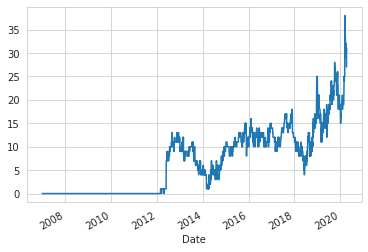

In [18]:
mask_netnet.groupby(DATE).sum().plot(grid=True);

We can also show all the tickers that have traded at NetNet discounts at some point:

In [19]:
tickers_netnet = mask_netnet[mask_netnet].reset_index()[TICKER].unique()
print('Number of unique tickers:', len(tickers_netnet))
print(tickers_netnet)

Number of unique tickers: 96
['ADIL' 'ADVM' 'AGLE' 'AHPI' 'AKER' 'ALPN' 'ALRN' 'AMDA' 'AMSC' 'ASCMA'
 'ASTC' 'AVGR' 'AWRE' 'BLFS' 'BSPM' 'BTAI' 'BVSN' 'CALA' 'CDI' 'CDNA'
 'CGA' 'CLBS' 'CLNT' 'CLRB' 'CRVS' 'CTIC' 'CVSI' 'CYCC' 'CYIG' 'EFOI'
 'EVLO' 'FNJN' 'FORD' 'FORM' 'FPRX' 'FRD' 'FTEK' 'GENC' 'GLYC' 'GTXI'
 'HGEN' 'HTGM' 'IAIC' 'IEP' 'IFON' 'IMDZ' 'IPDN' 'KKR' 'KURA' 'LEDS' 'LGL'
 'MB' 'MEIP' 'MICT' 'MN' 'MNKD' 'MRSN' 'MTEM' 'MXPT' 'NHTC' 'NLNK' 'NSPR'
 'OMED' 'ONVO' 'OPHT' 'PACB' 'PSDV' 'PTE' 'PTN' 'RIGL' 'RKDA' 'RUBI'
 'RWLK' 'SCND' 'SIGN' 'SMIT' 'SOHU' 'SORL' 'SPRT' 'SRPT' 'SRRA' 'STML'
 'SURF' 'TGTX' 'TMED' 'TOCA' 'TROV' 'TRT' 'UMRX' 'VIDE' 'VKTX' 'VLRX'
 'VSTM' 'WSTL' 'XPO' 'ZYNE']


## 1-Day Returns

Let us now compare the P/NetNet ratio to 1-day stock-returns.

In [20]:
# Name of the new column for the returns.
TOTAL_RETURN_1D = 'Total Return 1-Day'

In [21]:
%%time
# Calculate 1-day stock-returns.
df_returns_1d = hub.returns(name=TOTAL_RETURN_1D,
                            bdays=1, future=True, annualized=False)

Cache-file 'rel_change-20196410.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 63.8 ms, sys: 52 ms, total: 116 ms
Wall time: 115 ms


In [22]:
# Show the 1-day stock-returns.
df_returns_1d.loc[mask_netnet]

Ticker  Date      
ADIL    2019-11-29   -0.027586
        2019-12-02   -0.007092
        2019-12-03   -0.007143
        2019-12-04   -0.007194
        2019-12-05    0.094203
                        ...   
ZYNE    2019-01-22   -0.034853
        2019-01-23    0.013889
        2019-01-24    0.032877
        2019-01-25    0.018568
        2019-01-28    0.252604
Name: Total Return 1-Day, Length: 23018, dtype: float64

In [23]:
# Limit the daily returns between -10% and +10%
df_returns_1d = df_returns_1d.clip(-0.1, 0.1)

# Combine the signals and stock-returns.
# We are only using the rows which are NetNet discounts.
dfs = [df_signals.loc[mask_netnet],
       df_returns_1d.loc[mask_netnet]]
df_sig_rets = pd.concat(dfs, axis=1)

We can then make a scatter-plot of the P/NetNet ratio versus the daily stock-returns:

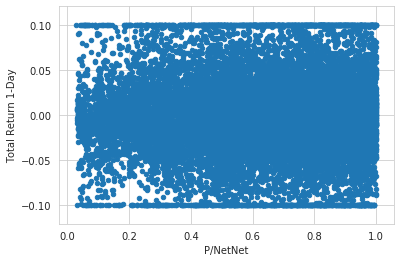

In [24]:
df_sig_rets.plot(kind='scatter', grid=True,
                 x=P_NETNET, y=TOTAL_RETURN_1D);

We can also use colours to distinguish the dots for different tickers:

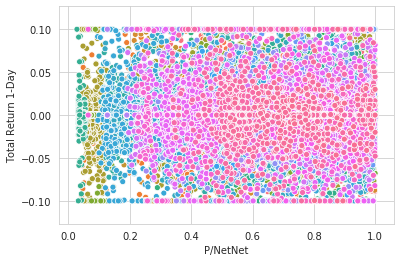

In [25]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1D, hue=TICKER,
                data=df_sig_rets.reset_index(), legend=False);

As you can see from the plots above, there is no clear relation between the P/NetNet ratio and daily stock-returns. The plot looks completely random and there is a very good reason for this, because the P/NetNet ratio is composed of two items: The daily share-price divided by the NetNet-value, which is calculated using data from the last-known quarterly Balance Sheet. So the NetNet value is the exact same for every single day for 3 months at a time. So we are essentially trying to use the share-price to predict 1-day stock-returns, which is quite moronic! This is also the case for other valuation ratios and signals that rely on data from the quarterly Income Statements, Balance Sheets and Cash-Flow Statements. Because that data will be exactly the same for 3 months at a time, so it cannot be used to predict short-term stock-returns.

## 1-3 Year Returns

Let us instead study the relation between the P/NetNet ratio and the average stock-returns for all 1-3 year investment periods. We will actually consider the mean log-returns, because that is easier to calculate, but the result is nearly the same as the non-log mean returns.

In [26]:
# Name of the new column for the returns.
TOTAL_RETURN_1_3Y = 'Total Return 1-3 Years'

In [27]:
%%time
# Calculate the mean log-returns for all 1-3 year periods.
df_returns_1_3y = \
    hub.mean_log_returns(name=TOTAL_RETURN_1_3Y,
                         future=True, annualized=True,
                         min_years=1, max_years=3)

Cache-file 'mean_log_change-5cec82bd.pickle' on disk (0 days old).
- Loading from disk ... Done!
CPU times: user 73.9 ms, sys: 52.3 ms, total: 126 ms
Wall time: 125 ms


In [28]:
# Combine the signals and stock-returns.
# We are only using the rows which are NetNet discounts.
dfs = [df_signals.loc[mask_netnet],
       df_returns_1_3y.loc[mask_netnet]]
df_sig_rets = pd.concat(dfs, axis=1)

Let us now make a scatter-plot of the P/NetNet ratio versus the 1-3 year average stock-returns. We use different colours for the individual tickers. There seems to be some kind of downward-sloping curves in this plot, but the outliers makes it a bit hard to see:

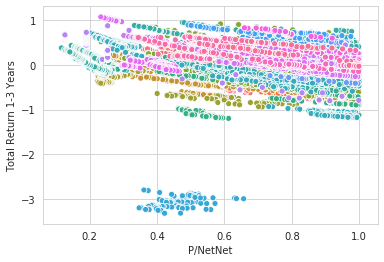

In [29]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_sig_rets.reset_index(), legend=False);

## Winsorize Data

A common method for removing outliers is so-called *Winsorization* of the data. It basically just limits or clips the data between e.g. the 5% and 95% quantiles of the data. We will Winsorize the stock-returns and all the signals except the P/NetNet ratio, because that is already limited between zero and one by using the stock-screener criterion above.

In [30]:
# Select all columns except for the P/NetNet ratio.
columns = df_sig_rets.columns.drop(P_NETNET)

# Winsorize all the other signals and stock-returns.
df_sig_rets2 = sf.winsorize(df_sig_rets, columns=columns)

We can now repeat the above scatter-plot for the P/NetNet ratio versus the 1-3 year average stock-returns. The colours are again for the different stock-tickers:

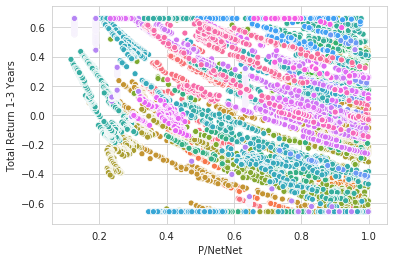

In [31]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_sig_rets2.reset_index(), legend=False);

Note how some of the values on the y-axis are squashed at the upper and lower boundaries, which is due to the clipping or limiting done in the Winsorization. This clipping is also done on all the signals, which may cause problems for the statistical analysis.

We can pass the argument `clip=False` to the Winsorization function, so instead of clipping or limiting all the values beyond the 5% and 95% quantiles, it simply sets them to `NaN` (Not-a-Number), so they will be ignored in the statistical analysis:

In [32]:
# Winsorize all the other signals and stock-returns.
# Instead of clipping values beyond the bounds, set them to NaN.
df_sig_rets = sf.winsorize(df_sig_rets, columns=columns, clip=False)

We can then make the scatter-plot again, where we see that all the clipped / squashed values at the upper and lower boundaries are now gone:

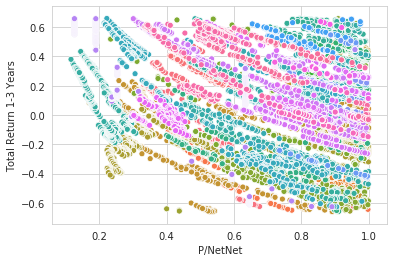

In [33]:
sns.scatterplot(x=P_NETNET, y=TOTAL_RETURN_1_3Y, hue=TICKER,
                data=df_sig_rets.reset_index(), legend=False);

The downard-sloping curves are now very clear in the plot above, if you separate the curves according to the different ticker-colours. The curves look so regular, that there must be some formula that governs their shape, so it would seem possible to predict the future stock-returns from the P/NetNet ratio, if we could also determine the *magic number* that shifts the curve up or down for the different stocks. We will discuss this towards the end of this tutorial. Let us now proceed with the statistical analysis of the other signals.

## Linear Correlation

Linear correlation (aka. Pearson correlation) is a simple statistical measure of how two variables change together. We will study the linear correlation between the signals and stock-returns, to roughly assess which signals might be the best predictors for stock-returns. We will also study the linear correlation between the signals themselves, to assess whether some of the signals seem to be redundant and can be removed.

A correlation value of +1 means the two variables are perfectly correlated, so they always increase and decrease together in a linear way. Conversely, a correlation value of -1 means the two variables are perfectly inversely correlated, so they always increase and decrease in the opposite direction of each other. A correlation value of zero means that there is no linear relation between the signal and stock-returns, but there may still be a strong non-linear relation (see examples [here](https://en.wikipedia.org/wiki/Correlation_and_dependence)).

We use the Winsorized data when studying the correlation, because data-outliers may falsely indicate a strong overall correlation, when in fact there is no correlation for the majority of the data.

Let us first show the correlation between all the signals and the 1-3 year average stock-returns, sorted according to the absolute correlation strength:

In [34]:
# Calculate the correlation between all signals and stock-returns.
df_corr = df_sig_rets.corr()

# Show how the signals are correlated with the stock-returns.
# Sorted to show the strongest absolute correlations first.
df_corr_returns = df_corr[TOTAL_RETURN_1_3Y].abs().sort_values(ascending=False)
df_corr_returns

Total Return 1-3 Years               1.000000
Gross Profit Margin                  0.289238
Sales Growth                         0.249793
Current Ratio                        0.208672
Quick Ratio                          0.201838
Log Revenue                          0.173677
P/NetNet                             0.150895
P/Cash                               0.146676
Market-Cap                           0.139700
Sales Growth YOY                     0.129381
Assets Growth QOQ                    0.119741
Net Profit Margin                    0.118657
P/NCAV                               0.116468
Assets Growth                        0.108599
Assets Growth YOY                    0.106224
Dividends / FCF                      0.105180
Earnings Growth YOY                  0.078414
P/FCF                                0.075118
Interest Coverage                    0.068385
CapEx / (Depr + Amor)                0.053645
Earnings Growth QOQ                  0.047754
P/Sales                           

We can also show a correlation-matrix between all the signals and the 1-3 year average stock-returns. Note that all correlations on the diagonal are 1 because each signal is perfectly correlated with itself. You should look for correlation values that are close to +1 or -1 because it means the two signals are redundant.

In [35]:
df_corr.round(2).style.background_gradient(cmap='seismic', axis=None)

Even for a small number of signals, the correlation matrix can easily get confusing. Instead, we can show only the larger correlations:

In [36]:
# Only show the large (absolute) correlation values.
df_corr2 = df_corr[df_corr.abs() > 0.7]

# Round correlation values to 2 digits.
df_corr2 = df_corr2.round(2)

# Transform the table to give a better overview.
df_corr2 = df_corr2.stack()

# Remove all values that are 1.0
df_corr2 = df_corr2[df_corr2 != 1.0]

# Show the result. Use a DataFrame for pretty printing.
pd.DataFrame(df_corr2, columns=['Correlation'])

Correlation
(Dividends + Share Buyback) / FCF Share Buyback / FCF                       0.98
Current Ratio                     Quick Ratio                               0.98
Net Profit Margin                 P/Sales                                  -0.85
Quick Ratio                       Current Ratio                             0.98
Return on Assets                  Return on Equity                          0.88
Return on Equity                  Return on Assets                          0.88
                                  Earnings Yield                            0.79
Share Buyback / FCF               (Dividends + Share Buyback) / FCF         0.98
Earnings Yield                    Return on Equity                          0.79
                                  FCF Yield                                 0.83
FCF Yield                         Earnings Yield                            0.83
P/Book                            P/NCAV                                    0.84
P/NCAV                            P/Book                                    0.84
                                  P/NetNet                                  0.83
P/NetNet                          P/NCAV                                    0.83
P/Sales                           Net Profit Margin                        -0.85

Strongly correlated variables may cause problems for the regression analysis we will do next, so in practice you would remove the highly correlated and least important signals.

## Linear Regression

We now perform so-called Linear Regression to assess whether there is a linear relation between the signals and stock-returns. We want to find the coefficients $\beta_i$ that minimize the sum of squared errors between the stock-returns predicted by this formula, and the actual stock-returns from the data. Note that $\epsilon$ is an error-term in this formula:

$$
    Stock\ Return = \beta_0 + \beta_1 \cdot P/NetNet + \beta_2 \cdot Gross\ Profit\ Margin + \ldots + \epsilon
$$

We will use the StatsModels package for this. We will perform the regression a few times, because we will remove some of the signals that turn out to be statistically insignificant, so it is useful to make a small helper-function.

This function also *standardizes* the signals so they have zero mean and one standard deviation. This serves two purposes: First, it helps the numeric computations when all signals are in the same value-range, otherwise e.g. the Market-Cap would have gigantic values while the P/NetNet ratios are between zero and one. Second, it makes it possible to roughly assess which signals are most important in predicting the stock-returns. But the standardization also means that you cannot use the regression coefficients directly to predict future stock-returns, as you first have to transform the signals before inputting them to the regression formula. We will not be using the regression model for predicting future stock-returns here, so the standardization of the signals is not a problem for us.

In [37]:
def regression(df, use_constant=True):
    """
    Perform multiple linear-regression on the given data.
    
    :param df:
        Pandas DataFrame with signals and returns.
        
    :param use_constant:
        Boolean whether to add a 'Constant' column to
        find the bias.
    
    :return:
        StatsModels Regression Results.
    """
    
    # Remove rows where all values are missing.
    df = df.dropna(how='any')

    # DataFrame which only contains the signals.
    df_x = df.drop(columns=[TOTAL_RETURN_1_3Y])
    
    # DataFrame which only contains the stock-returns.
    df_y = df[TOTAL_RETURN_1_3Y]

    # Standardize the signals so they have mean 0 and std 1.
    df_x = (df_x - df_x.mean()) / df_x.std()

    # Add a "constant" column so the regression can find the bias.
    if use_constant:
        df_x['Constant'] = 1.0

    # Perform the regression on this data.
    model = sm.OLS(df_y, df_x).fit()
    
    return model

### Regression Using Many Signals

We will not be using *all* the signals in the regression, because it removes all rows where some values are NaN (Not-a-Number). If we are using *all* the signals, then too many rows would be removed, and the regression results would not be representative of the entire dataset.

First note that we have this many rows of data to begin with:

In [38]:
len(df_sig_rets.dropna(how='all'))

23018

If we then select some of the signals that were found above to have the highest correlation with the future stock-returns, and remove all rows with NaN values, as will be done by the regression, then we only have a small fraction of the rows from the original DataFrame.

In [39]:
# Only use some of the signals.
columns = [TOTAL_RETURN_1_3Y, GROSS_PROFIT_MARGIN, SALES_GROWTH,
           CURRENT_RATIO, LOG_REVENUE, P_NETNET, P_CASH,
           MARKET_CAP, SALES_GROWTH_YOY, ASSETS_GROWTH_QOQ,
           NET_PROFIT_MARGIN, INTEREST_COVERAGE]
df = df_sig_rets[columns]

# Show number of rows without NaN values.
len(df.dropna(how='any'))

2005

We can then perform the regression on these signals. The results below show a lot of sophisticated statistical information that we don't really need. One of the most important statistics for us, is the "Adjusted R-squared" which is nearly 0.7, meaning that almost 70% of the variance in the stock-returns can be explained by a linear combination of these signals. This is a very good fit, but it might be too good to be true.

It should be noted, that if we had used Winsorization with clipping instead of setting the outliers to NaN (Not-a-Number), then the R-squared would have been lower. It is unclear whether this is due to the distortion introduced by the clipping, or if it is because there are fewer data-points when outliers are set to NaN.

In [40]:
# Perform the Linear Regression on the signals and stock-returns.
model = regression(df=df)

# Show the results.
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared:                       0.680
Model:                                OLS   Adj. R-squared:                  0.678
Method:                     Least Squares   F-statistic:                     385.1
Date:                    Sun, 12 Apr 2020   Prob (F-statistic):               0.00
Time:                            12:44:40   Log-Likelihood:                 843.64
No. Observations:                    2005   AIC:                            -1663.
Df Residuals:                        1993   BIC:                            -1596.
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin    -0.2423      0.006    -38.539      0.000      -0.255      -0.230
Sales Growth           -0.0541      0.006     -9.553      0.000      -0.065      -0.043
Current Ratio          -0.0875      0.006    -15.146      0.000      -0.099      -0.076
Log Revenue            -0.0990      0.010     -9.943      0.000      -0.118      -0.079
P/NetNet                0.0235      0.007      3.502      0.000       0.010       0.037
P/Cash                 -0.1223      0.005    -26.648      0.000      -0.131      -0.113
Market-Cap             -0.0768      0.007    -11.709      0.000      -0.090      -0.064
Sales Growth YOY       -0.0130      0.005     -2.540      0.011      -0.023      -0.003
Assets Growth QOQ       0.0065      0.005      1.329      0.184      -0.003       0.016
Net Profit Margin      -0.0146      0.006     -2.563      0.010      -0.026      -0.003
Interest Coverage      -0.0469      0.005     -9.027      0.000      -0.057      -0.037
Constant               -0.0246      0.004     -6.914      0.000      -0.032      -0.018
==============================================================================
Omnibus:                      176.541   Durbin-Watson:                   0.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              470.267
Skew:                          -0.486   Prob(JB):                    7.63e-103
Kurtosis:                       5.164   Cond. No.                         6.86
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Regression Using Only Significant Signals

Then we look at the column named "P>|t|" in the regression results shown above. This is the so-called p-value that each signal is statistically significant in predicting the stock-returns. P-values that are much greater than zero, means that the signal probably has a random effect on the stock-returns, so the signal can be omitted.

So let us remove the signals with a p-value greater than 0.05 because they are probably not useful, and then do the regression again. This procedure can be repeated several times, because each iteration may result in one or more signals having high p-values, so the signals should be removed and the regression run again. Finally we end up having removed several signals and get the following regression results:

In [41]:
# Only use some of the signals.
columns = [TOTAL_RETURN_1_3Y, GROSS_PROFIT_MARGIN, SALES_GROWTH,
           CURRENT_RATIO, LOG_REVENUE, P_NETNET, P_CASH,
           MARKET_CAP, INTEREST_COVERAGE]
df = df_sig_rets[columns]

# Perform the Linear Regression again using remaining signals.
model2 = regression(df=df)

# Show the results.
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared:                       0.428
Model:                                OLS   Adj. R-squared:                  0.426
Method:                     Least Squares   F-statistic:                     216.9
Date:                    Sun, 12 Apr 2020   Prob (F-statistic):          1.22e-274
Time:                            12:44:40   Log-Likelihood:                 346.54
No. Observations:                    2327   AIC:                            -675.1
Df Residuals:                        2318   BIC:                            -623.3
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin    -0.0974      0.006    -17.557      0.000      -0.108      -0.087
Sales Growth           -0.0517      0.005    -10.318      0.000      -0.062      -0.042
Current Ratio          -0.0554      0.006     -9.797      0.000      -0.066      -0.044
Log Revenue            -0.0259      0.008     -3.266      0.001      -0.041      -0.010
P/NetNet                0.0247      0.006      4.280      0.000       0.013       0.036
P/Cash                 -0.1160      0.005    -23.631      0.000      -0.126      -0.106
Market-Cap              0.0518      0.006      8.816      0.000       0.040       0.063
Interest Coverage      -0.0617      0.005    -13.176      0.000      -0.071      -0.053
Constant               -0.0059      0.004     -1.371      0.171      -0.014       0.003
==============================================================================
Omnibus:                      133.158   Durbin-Watson:                   0.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              470.811
Skew:                           0.171   Prob(JB):                    5.82e-103
Kurtosis:                       5.177   Cond. No.                         3.76
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We see from the above statistics that the "Adjusted R-squared" is now only about 0.43 (down from almost than 0.7), but now all the signals have p-values close to zero, so they are all statistically significant in predicting the stock-returns, and it is still a very good fit.

### Regression Coefficients

Let us show the regression coefficients and sort them in descending order, to show the largest coefficients first. Because we have *standardized* the signals so they have zero mean and one standard deviation, the regression coefficients can be used to roughly assess which signals are most important in predicting the stock-returns.

If we had used clipping to remove the outliers in Winsorization, then the regression coefficients would have been much lower. But it is again unclear whether this is due to the distortion introduced by the clipping, or because we have made the dataset smaller by setting outliers to NaN (Not-a-Number).

In [42]:
def sort_coefs(model):
    """Helper-function to sort regression coefficients."""
    return pd.Series(model.params).abs().sort_values(ascending=False)

In [43]:
# Show the regression coefficients for the signals.
sort_coefs(model=model2)

P/Cash                 0.115971
Gross Profit Margin    0.097440
Interest Coverage      0.061695
Current Ratio          0.055357
Market-Cap             0.051766
Sales Growth           0.051693
Log Revenue            0.025866
P/NetNet               0.024677
Constant               0.005937
dtype: float64

There is an important caveat, because if we remove just one signal, then the regression coefficients may change completely. For example, let us try and remove the Market-Cap signal which changes the regression coefficients and their mutual order:

In [44]:
# Perform the Linear Regression again using remaining signals.
model3 = regression(df=df.drop(columns=[MARKET_CAP]))

# Show the regression coefficients for the signals.
sort_coefs(model=model3)

P/Cash                 0.123586
Gross Profit Margin    0.084418
Sales Growth           0.077366
Interest Coverage      0.066623
Current Ratio          0.058710
P/NetNet               0.054684
Log Revenue            0.019338
Constant               0.014952
dtype: float64

### Regression Using One Signal

Another way of assessing which signals are most important, is to do the regression with only one signal at a time. For example, if we start with the Gross Profit Margin we see it has an R-squared value of about 0.08 which means that about 8% of the variance in the stock-returns is predicted by the Gross Profit Margin.

In [45]:
# Select the relevant data.
columns = [GROSS_PROFIT_MARGIN, TOTAL_RETURN_1_3Y]
df = df_sig_rets[columns]

# Perform the Linear Regression and show the results.
model4 = regression(df=df, use_constant=False)
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared (uncentered):                   0.083
Model:                                OLS   Adj. R-squared (uncentered):              0.083
Method:                     Least Squares   F-statistic:                              649.5
Date:                    Sun, 12 Apr 2020   Prob (F-statistic):                   2.99e-137
Time:                            12:44:40   Log-Likelihood:                         -1218.0
No. Observations:                    7202   AIC:                                      2438.
Df Residuals:                        7201   BIC:                                      2445.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin    -0.0861      0.003    -25.486      0.000      -0.093      -0.079
==============================================================================
Omnibus:                      400.989   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.857
Skew:                           0.196   Prob(JB):                     1.61e-41
Kurtosis:                       2.313   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we then do the regression for the P/NetNet signal we see that it has an R-squared value of about 0.02, so it only predicts about 2% of the variance in the stock-returns.

In [46]:
# Select the relevant data.
columns = [P_NETNET, TOTAL_RETURN_1_3Y]
df = df_sig_rets[columns]

# Perform the Linear Regression and show the results.
model5 = regression(df=df, use_constant=False)
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared (uncentered):                   0.022
Model:                                OLS   Adj. R-squared (uncentered):              0.022
Method:                     Least Squares   F-statistic:                              225.6
Date:                    Sun, 12 Apr 2020   Prob (F-statistic):                    1.95e-50
Time:                            12:44:40   Log-Likelihood:                         -2589.7
No. Observations:                   10012   AIC:                                      5181.
Df Residuals:                       10011   BIC:                                      5189.
Df Model:                               1                                                  
Covariance Type:                nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
P/NetNet      -0.0470      0.003    -15.019      0.000      -0.053      -0.041
==============================================================================
Omnibus:                      756.564   Durbin-Watson:                   0.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.324
Skew:                          -0.008   Prob(JB):                     2.66e-55
Kurtosis:                       2.224   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we do the regression for both the Gross Profit Margin and P/NetNet, then we get an R-squared value of about 0.08, so when they are taken together, they predict about 8% of the variance in the stock-returns.

In [47]:
# Select the relevant data.
columns = [GROSS_PROFIT_MARGIN, P_NETNET, TOTAL_RETURN_1_3Y]
df = df_sig_rets[columns]

# Perform the Linear Regression and show the results.
model6 = regression(df=df, use_constant=False)
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                  
===========================================================================================
Dep. Variable:     Total Return 1-3 Years   R-squared (uncentered):                   0.083
Model:                                OLS   Adj. R-squared (uncentered):              0.082
Method:                     Least Squares   F-statistic:                              324.7
Date:                    Sun, 12 Apr 2020   Prob (F-statistic):                   9.57e-136
Time:                            12:44:40   Log-Likelihood:                         -1218.0
No. Observations:                    7202   AIC:                                      2440.
Df Residuals:                        7200   BIC:                                      2454.
Df Model:                               2                                                  
Covariance Type:                nonrobust                                                  
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Gross Profit Margin    -0.0861      0.003    -25.383      0.000      -0.093      -0.079
P/NetNet            -4.008e-05      0.003     -0.012      0.991      -0.007       0.007
==============================================================================
Omnibus:                      401.153   Durbin-Watson:                   0.025
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.884
Skew:                           0.196   Prob(JB):                     1.59e-41
Kurtosis:                       2.313   Cond. No.                         1.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Scatter Plots

Regression can result in highly misleading results if we are not careful. The problem is that statistical methods often make assumptions about the data, e.g. that there is a linear relation in the data, or that the data is normally distributed, etc. When we are using statistical methods on data that violates the assumptions, we can get some very strange and misleading results.

Often it is much more useful to make plots of the data. Even the founders of statistical science considered this to be a completely valid and sometimes even necessary approach to studying data. Fortunately this is very easy using Python and modern plotting packages such as Seaborn.

Let us make some scatter-plots of the most important signals versus the stock-returns.

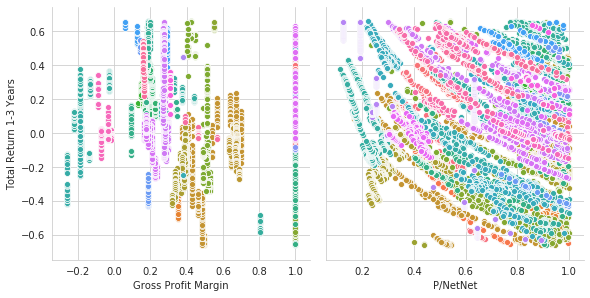

In [48]:
# Plot these signals on the x-axis.
x_vars = [GROSS_PROFIT_MARGIN, P_NETNET]

# Plot the stock-returns on the y-axis
y_vars = [TOTAL_RETURN_1_3Y]

# Create the plots.
g = sns.PairGrid(df_sig_rets.reset_index(), height=4,
                 x_vars=x_vars, y_vars=y_vars, hue=TICKER)
g.map(sns.scatterplot);

The colours in these plots represent different stock-tickers. The Gross Profit Margin was found further above to be one of the most important signal for predicting the future stock-returns over 1-3 year investment periods. But when we look at this scatter-plot, there is no clear relation between the Gross Profit Margin and stock-returns.

The second scatter-plot is for the P/NetNet signal. This had a lower R-squared value than the Gross Profit Margin. But in this plot we see clear and characteristic downward-sloping curves, if we separate them by the ticker-colours, which we will discuss below.

## Discussion

Statistical analysis is a very blunt tool for uncovering relations between financial signals and stock-returns. Even if a statistical method finds a significant relation, it may be highly misleading because the data violates the assumptions of the statistical model. And even if the data is valid for a given statistical model, we might not be able to distinguish between correlation and causation, so we cannot tell if the signal really has any predictive power.

Most academic papers in finance only use statistical methods such as regression analysis. It is therefore questionable how useful such papers really are. Some researchers think the solution is to use ever-more sophisticated statistical methods, but that only seems to bring them further away from uncovering the true relation in the data.

Plotting the data may reveal much more than statistical methods can. In the examples above, we saw how the scatter-plot of the P/NetNet ratio versus the stock-returns had characteristic downward-sloping curves, when we separated the data according to the different colours for the stock-tickers. The curves were apparently just shifted up or down for the different stock-tickers, but otherwise the curve had a common shape for the stocks. This observation is a great starting-point for further scientific inquiry into the true relation between the P/NetNet ratio and stock-returns.

Interestingly, a very similar discovery was already made [here](https://github.com/Hvass-Labs/FinanceOps/blob/master/01B_Better_Long-Term_Stock_Forecasts.ipynb) when using the P/Sales ratio to predict long-term stock-returns of some major stocks, as well as the S&P 500 stock-market index as a whole. The exact formula for the downward-sloping curves was derived [here](https://github.com/Hvass-Labs/FinanceOps/blob/master/01C_Theory_of_Long-Term_Stock_Forecasting.ipynb) and actually follows from the definition of annualized return. When using the P/Sales ratio as the predictor variable, there are only 3 underlying sources of stock-return for the long-term investor: The dividend yield, sales growth, and the change in P/Sales ratio. From our experiments above, it seems that something similar might hold for NetNet-stocks. 

This is a good lesson on how to do proper science in finance. If physicists only used statistical methods, we would still not know any laws of physics. But most academic researchers in finance don't venture beyond the statistical methods, so they cannot discover how finance actually works, and that is why academic finance is still in the dark ages. This is unfortunate for the world, because it probably causes the extremely volatile stock-markets we often experience. But it is very fortunate for you, because it means there are plenty of opportunities for you to make important scientific discoveries in finance. Hopefully this dataset and beautiful Python API will help you change the world.

## License (MIT)

This is published under the
[MIT License](https://github.com/simfin/simfin-tutorials/blob/master/LICENSE.txt)
which allows very broad use for both academic and commercial purposes.

You are very welcome to modify and use this source-code in your own project. Please keep a link to the [original repository](https://github.com/simfin/simfin-tutorials).
